<Figure size 800x400 with 0 Axes>

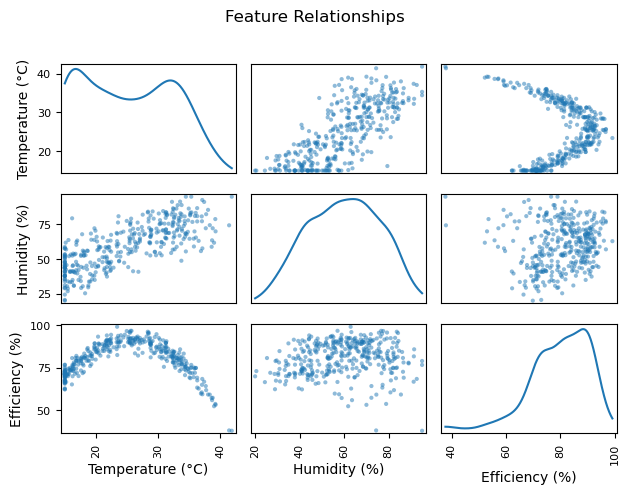

XGBoost R²: 0.924
MAE: 1.81%


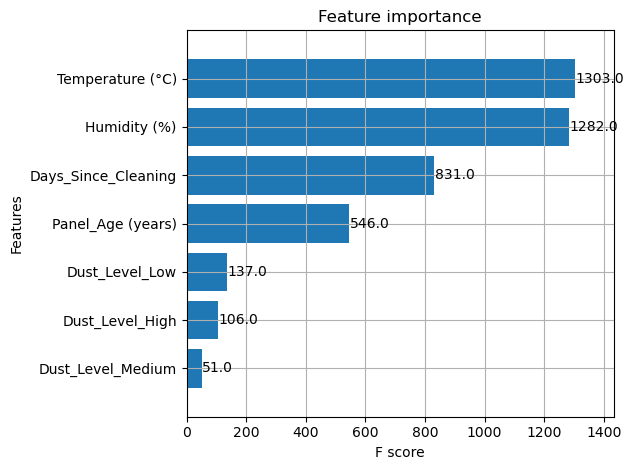

In [1]:
# # Solar Panel Efficiency Prediction (Exploration)
# ### Data Generation & Model Testing

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# %% [markdown]
# ## 1. Generate Synthetic Data

# %%
def generate_efficiency_data():
    dates = pd.date_range("2023-01-01", periods=365)
    
    # Realistic weather patterns
    temp = 25 + 10 * np.sin(2 * np.pi * (dates.dayofyear - 105) / 365)  # Seasonal variation
    humidity = 60 + 20 * np.cos(2 * np.pi * (dates.dayofyear - 200) / 365)
    
    data = {
        "Temperature (°C)": np.clip(temp + np.random.normal(0, 3, 365), 15, 45),
        "Humidity (%)": np.clip(humidity + np.random.normal(0, 10, 365), 20, 95),
        "Dust_Level": np.random.choice(["Low", "Medium", "High"], 365, p=[0.6, 0.3, 0.1]),
        "Days_Since_Cleaning": np.random.randint(1, 31, 365),
        "Panel_Age (years)": np.random.randint(0, 11, 365),
    }
    
    # Physics-based efficiency formula
    data["Efficiency (%)"] = (
        92 
        - 0.5 * data["Panel_Age (years)"]  # Aging
        - 0.15 * data["Days_Since_Cleaning"]  # Dust accumulation
        - 3 * (data["Dust_Level"] == "Medium") 
        - 7 * (data["Dust_Level"] == "High")
        - 0.2 * (data["Temperature (°C)"] - 25) ** 2  # Temp quadratic penalty
        + 0.1 * data["Humidity (%)"]  # Humidity impact
        + np.random.normal(0, 1.5, 365)  # Noise
    )
    return pd.DataFrame(data, index=dates)

df = generate_efficiency_data()
df.head()

# ## 2. Exploratory Data Analysis

# Correlation Heatmap
plt.figure(figsize=(8,4))
pd.plotting.scatter_matrix(df[['Temperature (°C)', 'Humidity (%)', 'Efficiency (%)']], diagonal='kde')
plt.suptitle("Feature Relationships", y=1.02)
plt.tight_layout()
plt.show()

# ## 3. Model Training

# Preprocessing
X = pd.get_dummies(df.drop("Efficiency (%)", axis=1))
y = df["Efficiency (%)"]

# Import XGBoost and other essentials
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

# Generate data (same as before)
df = generate_efficiency_data()
X = pd.get_dummies(df.drop("Efficiency (%)", axis=1))
y = df["Efficiency (%)"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
print(f"XGBoost R²: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}%")

# Feature Importance (XGBoost version)
xgb.plot_importance(xgb_model, height=0.8)
plt.tight_layout()
plt.show()

